In [1]:
import csv
import numpy as np
import pandas as pd

import os

from IPython.display import HTML, display

import matplotlib.cm as cm

import PIL
from PIL import Image

import torch
import torch.utils.data as data_utils
import torchvision.models as models
from torch.nn.modules import CrossEntropyLoss, L1Loss
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn

import time

#### Declaration of constants to be used in the notebook

In [2]:
DATA_PATH = 'datasets/'

SAMPLE_MOVIE_POSTERS_PATH = DATA_PATH + 'posters/'
MOVIE_GENRE_FILE = DATA_PATH + 'MovieGenre.csv'

SAMPLE_DATASET_SIZE = 60

TRAINING_SET_PROPORTION = 0.70

BATCH_SIZE = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
NUM_EPOCHS = 5
CLEAR_GRAD_TRAIN = False
USE_GPU = False

### Dataset Inspection

#### 1. Movie Genres

Read the Movie Genre file

In [3]:
data = []

with open(MOVIE_GENRE_FILE, 'r', encoding='latin1') as f:
    csv_reader = csv.reader(f)

    for row in csv_reader:
        data.append(row)

Print the first few entries to inspect the structure of data

In [4]:
data[0:5]

[['imdbId', 'Imdb Link', 'Title', 'IMDB Score', 'Genre', 'Poster'],
 ['114709',
  'http://www.imdb.com/title/tt114709',
  'Toy Story (1995)',
  '8.3',
  'Animation|Adventure|Comedy',
  'https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg'],
 ['113497',
  'http://www.imdb.com/title/tt113497',
  'Jumanji (1995)',
  '6.9',
  'Action|Adventure|Family',
  'https://images-na.ssl-images-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UY268_CR10,0,182,268_AL_.jpg'],
 ['113228',
  'http://www.imdb.com/title/tt113228',
  'Grumpier Old Men (1995)',
  '6.6',
  'Comedy|Romance',
  'https://images-na.ssl-images-amazon.com/images/M/MV5BMjQxM2YyNjMtZjUxYy00OGYyLTg0MmQtNGE2YzNjYmUyZTY1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg'],
 ['114885',
  'http://www.imdb.com/title/tt114885',
  'Waiting to Exhale (1995)',
  '5.7',
 

Create a dataframe from the data, using the entries at the first index as the column headers

In [5]:
columns = data.pop(0)

columns = list(map(lambda x: x.lower().replace(' ', '_'), columns))
movie_genre_df = pd.DataFrame(data, columns=columns)

Inspect the dataframe

In [6]:
movie_genre_df.shape

(40108, 6)

In [7]:
movie_genre_df.head()

,imdbid,imdb_link,title,imdb_score,genre,poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


Process the dataframe so that genres can be accessed easily further on 

In [8]:
# Split genre to create a list of values 
movie_genre_df['genre'] = movie_genre_df['genre'].apply(lambda x: x.split('|'))

# Expand genre into its own dataframe
tags = movie_genre_df['genre'].apply(pd.Series).fillna('')

# Rename the columns
tags = tags.rename(columns = lambda x : 'genre_' + str(x))

# Merge the genre dataframe back into the original dataframe
movie_genre_df = pd.concat([movie_genre_df[:], tags[:]], axis=1)

Inspect the dataframe

In [9]:
movie_genre_df.shape

(40108, 9)

In [10]:
movie_genre_df.head()

,imdbid,imdb_link,title,imdb_score,genre,poster,genre_0,genre_1,genre_2
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,"[Animation, Adventure, Comedy]",https://images-na.ssl-images-amazon.com/images...,Animation,Adventure,Comedy
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,"[Action, Adventure, Family]",https://images-na.ssl-images-amazon.com/images...,Action,Adventure,Family
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,"[Comedy, Romance]",https://images-na.ssl-images-amazon.com/images...,Comedy,Romance,
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,"[Comedy, Drama, Romance]",https://images-na.ssl-images-amazon.com/images...,Comedy,Drama,Romance
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,"[Comedy, Family, Romance]",https://images-na.ssl-images-amazon.com/images...,Comedy,Family,Romance


Retrieve the distribution of unique genres across all movies

In [11]:
# Get distribution of unique values from multiple genre columns
# Remove the entry representing no genre
# Get combined counts of unique genres

genre_distribution = movie_genre_df[['genre_0', 'genre_1', 'genre_2']] \
            .apply(lambda s: s.value_counts()) \
            .drop('') \
            .sum(axis=1) \
            .reset_index()
                
# Rename the columns acordingly                
genre_distribution.columns = ['genre', 'count']

# Sort the dataframe to order by predominant genres 
genre_distribution = genre_distribution.sort_values(by='count', ascending=False).reset_index(drop=True)

# Store the unique genres as a dictionary
unique_genres = genre_distribution['genre'].tolist()
unique_genres = {x: i for (i,x) in enumerate(unique_genres)}
unique_genres[''] = len(unique_genres)

Visualise the distribution of genres across movies

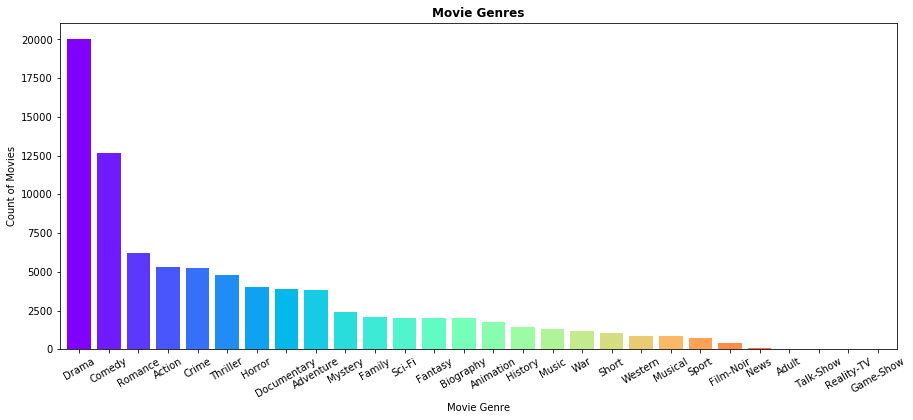

In [12]:
genres_count = genre_distribution.shape[0]
colors = cm.rainbow(np.linspace(0, 1, genres_count))


plot = genre_distribution.plot(x='genre', y='count', kind='bar', width=0.8, rot=0, figsize=(15,6), 
                               color=colors, legend=None)

plot.set_title('Movie Genres', fontweight='bold')

plot.set_ylabel('Count of Movies')
plot.set_xlabel('Movie Genre')

plot.set_xticklabels(labels=genre_distribution['genre'], rotation=30)

# plot.get_xaxis().set_ticks(rotation=30)

# rects = plot.patches

# # Now make some labels
# labels = [int(genre_distribution['count'][i]) for i in range(len(rects))]

# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     plot.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plot.get_figure() #.save_fig('')

#### 2. Sample Movie Posters

Create a list of the sample movie posters names by traversing the directory

In [13]:
poster_files = os.listdir(SAMPLE_MOVIE_POSTERS_PATH)

imdb_ids = [i.split('.')[0] for i in poster_files]
sample_movie_posters = [SAMPLE_MOVIE_POSTERS_PATH + i for i in poster_files]

print("Number of sample movie posters =", len(sample_movie_posters))

Number of sample movie posters = 997


Create a mini-batch of posters and associated genres.

In [14]:
mini_batch_posters = sample_movie_posters[0:SAMPLE_DATASET_SIZE]

mini_batch_genre1 = movie_genre_df[movie_genre_df['imdbid'].isin(imdb_ids[0:SAMPLE_DATASET_SIZE])]['genre_0'].tolist()
mini_batch_genre2 = movie_genre_df[movie_genre_df['imdbid'].isin(imdb_ids[0:SAMPLE_DATASET_SIZE])]['genre_1'].tolist()
mini_batch_genre3 = movie_genre_df[movie_genre_df['imdbid'].isin(imdb_ids[0:SAMPLE_DATASET_SIZE])]['genre_2'].tolist()

mini_batch_genre1_ids = [unique_genres[i] for i in mini_batch_genre1]
mini_batch_genre2_ids = [unique_genres[i] for i in mini_batch_genre2]
mini_batch_genre3_ids = [unique_genres[i] for i in mini_batch_genre3]

num_classes = len(unique_genres) - 1

Visualise the sample movie posters

In [15]:
markup = '<table>'

for i, poster in enumerate(mini_batch_posters):
    if i%12 == 0:
        markup += '</tr/><tr>'

    markup += '<td><img src=' + poster +' width="70" height="70"/><span>' + mini_batch_genre1[i] + '</span</td>'
    
markup += '</table>'

display(HTML(markup))

Drama</span,Drama</span,Crime</span,Drama</span,Short</span,Comedy</span,Documentary</span,Adventure</span,Comedy</span,Crime</span,Comedy</span,Comedy</span
Drama</span,Short</span,Comedy</span,Comedy</span,Music</span,Crime</span,Romance</span,Drama</span,Comedy</span,Drama</span,Drama</span,Drama</span
Comedy</span,Drama</span,Drama</span,Drama</span,Drama</span,Drama</span,Comedy</span,Drama</span,Crime</span,Drama</span,Action</span,Drama</span
Comedy</span,Drama</span,Mystery</span,Drama</span,Adventure</span,Romance</span,Romance</span,Animation</span,Drama</span,Drama</span,Short</span,Drama</span
Adventure</span,Short</span,Comedy</span,Drama</span,Comedy</span,Adventure</span,Drama</span,Comedy</span,Drama</span,Romance</span,Crime</span,Musical</span


Inspect the dimensions of one of the posters

In [16]:
sample_poster = np.array(PIL.Image.open(mini_batch_posters[0]))
print("Poster dimensions :", sample_poster.shape)

Poster dimensions : (268, 182, 3)


Resize the posters as square images are nice to work with and also convert them into numpy arrays

In [17]:
X = np.array([np.array(PIL.Image.open(i).resize((224,224))).T for i in mini_batch_posters])
X = X.transpose([0, 1, 3, 2])
               
template = np.concatenate((np.eye(num_classes), np.zeros((1, num_classes)))) 

y = template[mini_batch_genre1_ids] + template[mini_batch_genre2_ids] + template[mini_batch_genre3_ids]
 #np.array(mini_batch_genres)
    
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (60, 3, 224, 224)
y shape:  (60, 28)


### Model preparation

#### 1. Partition the data into training and test sets

In [18]:
train_size = int(len(X)*TRAINING_SET_PROPORTION)

X_train = X[:train_size]
y_train= y[:train_size]

X_test = X[train_size:]
y_test= y[train_size:]

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (42, 3, 224, 224)
y_train shape:  (42, 28)
X_test shape:  (18, 3, 224, 224)
y_test shape:  (18, 28)


Create Tensor objects for the training and test sets

In [19]:
X_train=torch.from_numpy(X_train).float()
X_test=torch.from_numpy(X_test).float()
y_train=torch.from_numpy(y_train)
y_test=torch.from_numpy(y_test)

train = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

test = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

dataset_sizes = {'train': len(train_loader), 'val': 0}

Download a pretrained model and adapt it

In [20]:
# Download a pretrained AlexNet model
alexnet = models.alexnet(pretrained=True)
model = alexnet
print('AlexNet Model', model)

# for param in model.parameters():
#     param.requires_grad = False

# Remove last layer
new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
model.classifier = new_classifier

# Add custom layer to predict num_classes
model.classifier._modules['6'] = nn.Linear(4096, num_classes)
print('Custom Model', model)

model.use_memory = False

AlexNet Model AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)
Custom Model A

Define the parameters required for training the model

In [21]:
criterion = nn.MultiLabelSoftMarginLoss()

# Define the appropriate image pre-processing function
preprocessFn = transforms.Compose([transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

In [22]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [29]:
def train_model(lr_scheduler):
    since = time.time()

    best_model = model
    best_accuracy = 0.0

    # Observe that all parameters are being optimized
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        print('Epoch {}/{}'.format(epoch, NUM_EPOCHS - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:#, 'val']:
            if phase == 'train':
#                 optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (inputs, targets) in enumerate(train_loader):

                if USE_GPU:
                    inputs = Variable(preprocessFn(inputs).cuda())
                    targets = Variable(target.cuda()).float()
                else:
                    inputs = Variable(preprocessFn(inputs))
                    targets = Variable(targets).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                i, max_targets = torch.max(targets.data, 1)
        
#                 outputs = nn.Softmax()(outputs)
                loss = criterion(outputs, targets)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == max_targets)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects / dataset_sizes[phase]

            print('{} loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))

            # deep copy the model
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model = np.copy(model)

        print('*' * 100)
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best validation accuracy: {:4f}'.format(best_accuracy))
#     return best_model

In [30]:
model_ft = train_model(exp_lr_scheduler)

Epoch 0/4
----------
train loss: 15.4536 Accuracy: 0.0000
****************************************************************************************************
Epoch 1/4
----------
train loss: 14.9800 Accuracy: 0.0000
****************************************************************************************************
Epoch 2/4
----------
train loss: 14.7235 Accuracy: 0.0000
****************************************************************************************************
Epoch 3/4
----------
train loss: 15.4734 Accuracy: 0.0000
****************************************************************************************************
Epoch 4/4
----------
train loss: 16.1247 Accuracy: 0.0000
****************************************************************************************************
Training complete in 0m 44s
